# RNN Model

## Training

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, f1_score
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

df=pd.read_csv('RELIANCE.csv')

# Extract Close prices
data = df[['Close']].dropna()

# Add returns & volatility
data['Return'] = data['Close'].pct_change()
data['Volatility'] = data['Return'].rolling(window=7).std()
data.dropna(inplace=True)

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length=60):
    X, y_price, y_volatility, y_direction = [], [], [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y_price.append(data[i, 0])  # Close
        y_volatility.append(data[i, 2])  # Volatility
        y_direction.append(1 if data[i, 0] > data[i-1, 0] else 0)  # Direction
    return np.array(X), np.array(y_price), np.array(y_volatility), np.array(y_direction)

seq_length = 60
X, y_price, y_vol, y_dir = create_sequences(scaled_data, seq_length)

# Train/test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_price_train, y_price_test = y_price[:split], y_price[split:]
y_vol_train, y_vol_test = y_vol[:split], y_vol[split:]
y_dir_train, y_dir_test = y_dir[:split], y_dir[split:]


## Model fitting

In [4]:
model = Sequential()
model.add(SimpleRNN(64, activation='tanh', input_shape=(seq_length, X.shape[2])))
model.add(Dense(2))  # One for price, one for volatility
model.compile(optimizer='adam', loss='mean_squared_error')

y_train_combined = np.column_stack((y_price_train, y_vol_train))
y_test_combined = np.column_stack((y_price_test, y_vol_test))

model.fit(X_train, y_train_combined, epochs=20, batch_size=32, validation_split=0.1)




Epoch 1/20

118/118 [==============================] - 2s 6ms/step - loss: 0.0051 - val_loss: 4.4135e-04
Epoch 2/20
118/118 [==============================] - 0s 4ms/step - loss: 0.0011 - val_loss: 3.3330e-04
Epoch 3/20
118/118 [==============================] - 1s 4ms/step - loss: 9.1561e-04 - val_loss: 2.2476e-04
Epoch 4/20
118/118 [==============================] - 1s 4ms/step - loss: 7.8858e-04 - val_loss: 0.0011
Epoch 5/20
118/118 [==============================] - 0s 4ms/step - loss: 6.9778e-04 - val_loss: 2.0991e-04
Epoch 6/20
118/118 [==============================] - 1s 4ms/step - loss: 6.1002e-04 - val_loss: 1.4248e-04
Epoch 7/20
118/118 [==============================] - 1s 5ms/step - loss: 6.0190e-04 - val_loss: 3.7723e-04
Epoch 8/20
118/118 [==============================] - 1s 5ms/step - loss: 5.4372e-04 - val_loss: 1.2113e-04
Epoch 9/20
118/118 [==============================] - 0s 4ms/step - loss: 5.3140e-04 - val_loss: 1.8398e-04
Epoch 10/20
118/118 [================

In [5]:
clf_model = Sequential()
clf_model.add(SimpleRNN(64, activation='tanh', input_shape=(seq_length, X.shape[2])))
clf_model.add(Dense(1, activation='sigmoid'))
clf_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

clf_model.fit(X_train, y_dir_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20

118/118 [==============================] - 1s 6ms/step - loss: 0.6967 - accuracy: 0.5073 - val_loss: 0.6909 - val_accuracy: 0.5357
Epoch 2/20
118/118 [==============================] - 1s 4ms/step - loss: 0.6938 - accuracy: 0.5134 - val_loss: 0.6913 - val_accuracy: 0.5357
Epoch 3/20
118/118 [==============================] - 1s 4ms/step - loss: 0.6929 - accuracy: 0.5142 - val_loss: 0.6906 - val_accuracy: 0.5357
Epoch 4/20
118/118 [==============================] - 1s 4ms/step - loss: 0.6926 - accuracy: 0.5179 - val_loss: 0.6964 - val_accuracy: 0.4667
Epoch 5/20
118/118 [==============================] - 1s 5ms/step - loss: 0.6928 - accuracy: 0.5139 - val_loss: 0.6999 - val_accuracy: 0.4643
Epoch 6/20
118/118 [==============================] - 1s 5ms/step - loss: 0.6916 - accuracy: 0.5195 - val_loss: 0.6964 - val_accuracy: 0.5357
Epoch 7/20
118/118 [==============================] - 0s 4ms/step - loss: 0.6996 - accuracy: 0.5113 - val_loss: 0.6913 - val_accuracy: 0.5357
Epoch

In [6]:
# Predict regression outputs (price & volatility)
reg_preds = model.predict(X_test)
pred_price = reg_preds[:, 0]
pred_vol = reg_preds[:, 1]

# Predict direction
pred_dir_probs = clf_model.predict(X_test)
pred_dir = (pred_dir_probs.flatten() > 0.5).astype(int)


33/33 [==============================] - 0s 2ms/step


In [7]:
# Inverse scaling for price and volatility
# Create dummy arrays for inverse_transform
dummy = np.zeros((len(pred_price), scaled_data.shape[1]))
dummy[:, 0] = pred_price
dummy[:, 2] = pred_vol
inv = scaler.inverse_transform(dummy)
inv_pred_price = inv[:, 0]
inv_pred_vol = inv[:, 2]

dummy[:, 0] = y_price_test
dummy[:, 2] = y_vol_test
inv_true = scaler.inverse_transform(dummy)
true_price = inv_true[:, 0]
true_vol = inv_true[:, 2]

## Metrics

In [12]:
# Regression Metrics
mse_price = mean_squared_error(true_price, inv_pred_price)
rmse_price = math.sqrt(mse_price)
mae_price = mean_absolute_error(true_price, inv_pred_price)

mse_vol = mean_squared_error(true_vol, inv_pred_vol)
rmse_vol = math.sqrt(mse_vol)
mae_vol = mean_absolute_error(true_vol, inv_pred_vol)

# Classification Metric (F1 Score)
f1 = f1_score(y_dir_test, pred_dir, zero_division=1)

# Compare each predicted price to the previous actual price
true_direction = (true_price[1:] > true_price[:-1]).astype(int)
pred_direction = (inv_pred_price[1:] > true_price[:-1]).astype(int)

# Calculate accuracy
accuracy = np.mean(true_direction == pred_direction)


In [13]:
print("\n🔮 Price Prediction Metrics:")
print(f" MAE: {mae_price:.4f}")
print(f" MSE: {mse_price:.4f}")
print(f" RMSE: {rmse_price:.4f}")

print("\n📉 Volatility Prediction Metrics:")
print(f" MAE: {mae_vol:.6f}")
print(f" MSE: {mse_vol:.6f}")
print(f" RMSE: {rmse_vol:.6f}")

print("\n🔁 Direction Prediction Metric:")
print(f" F1 Score: {f1:.4f}")
print(f" Accuracy (direction-based): {accuracy:.4f}")


🔮 Price Prediction Metrics:
 MAE: 21.9619
 MSE: 1590.9779
 RMSE: 39.8871

📉 Volatility Prediction Metrics:
 MAE: 0.002529
 MSE: 0.000046
 RMSE: 0.006794

🔁 Direction Prediction Metric:
 F1 Score: 0.6826
 Accuracy (direction-based): 0.5138


## Time series graph

C:\Users\asus\AppData\Local\Temp\ipykernel_146932\1578006404.py:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\asus\tf-env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


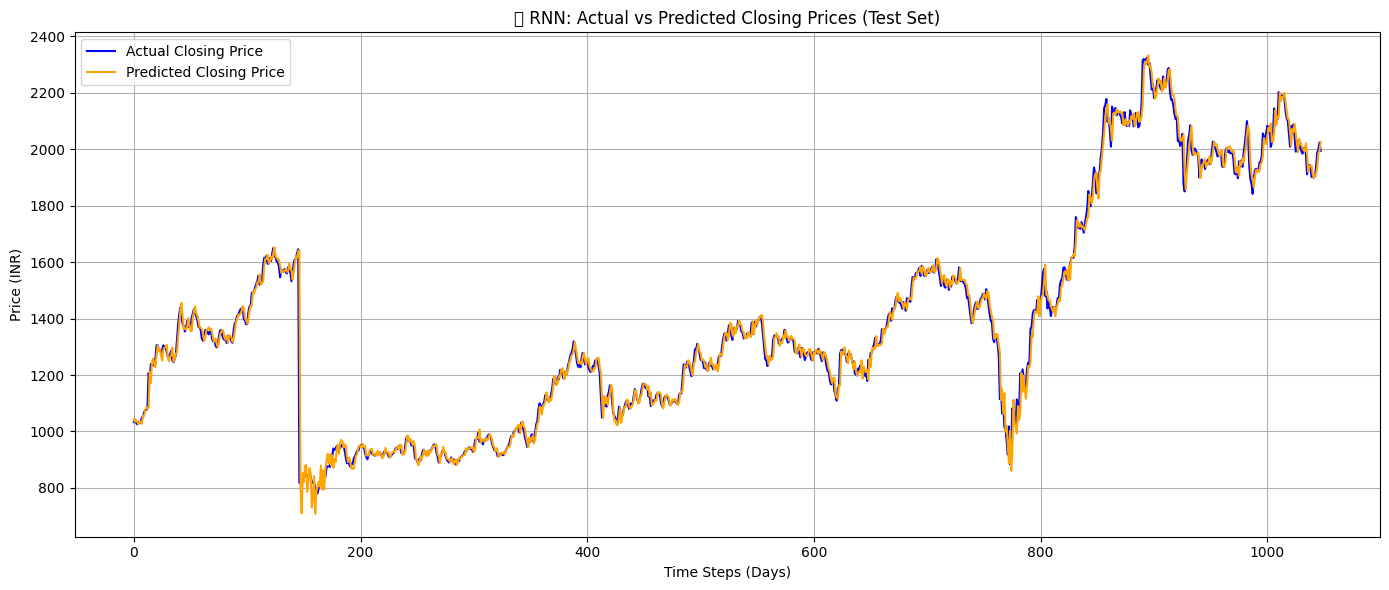

In [11]:
import matplotlib.pyplot as plt

# Plot actual vs predicted closing prices
plt.figure(figsize=(14,6))
plt.plot(true_price, label='Actual Closing Price', color='blue')
plt.plot(inv_pred_price, label='Predicted Closing Price', color='orange')
plt.title("📈 RNN: Actual vs Predicted Closing Prices (Test Set)")
plt.xlabel("Time Steps (Days)")
plt.ylabel("Price (INR)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
